In [80]:
import gym
from gym import spaces

import warnings
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import A2C
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines import PPO2

from aequam_env import AequamEnv

In [2]:
def rescale(df, start_int = 0, base = 100):
    return(df/np.array(df.iloc[start_int,:])*base)

In [3]:
df_obs = pd.read_csv('data/dataset5.csv', index_col = 0, parse_dates=True)
del df_obs['Equi_weighted']
df_prices = pd.read_csv('data/test.csv', index_col = 0, parse_dates=True, usecols = [i for i in range(7)]).loc[df_obs.index,:]


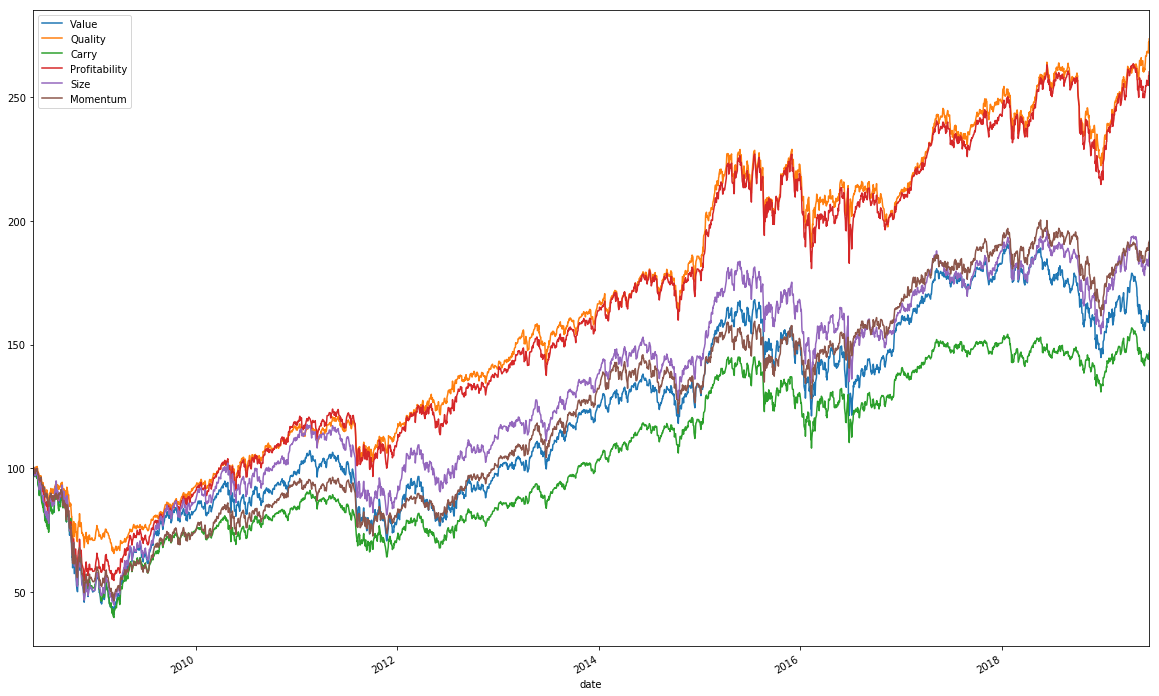

In [4]:
# plt.figure()
rescale(df_prices).iloc[::1,:].plot(figsize=(20,13))
plt.show()

In [5]:
from stable_baselines.results_plotter import load_results, ts2xy

best_mean_reward, n_steps = -np.inf, 0
def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    (continues on next page)
    10 Chapter 1. Main differences with OpenAI Baselines
    Stable Baselines Documentation, Release 2.7.0
    (continued from previous page)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))
            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True
# Create log dir
log_dir = "tmp"
os.makedirs(log_dir, exist_ok=True)

In [93]:
class AequamEnv(gym.Env):
    metadata = {'render.modes': ['human', 'live', 'file']}
    visualization = None

    def __init__(self, df_obs, df_prices, lookback_window = 5, transaction_cost = 0.001, starting_cash = 100.0, \
                max_balance = 1000.0, reward_type='delayed', transaction_smoothing = 3):
  
        super(AequamEnv, self).__init__()
    
        #.....
        #More initialisation parameters
        self.lookback_window = lookback_window
        self.transaction_cost = transaction_cost
        self.total_tc = 0.0
        self.starting_cash = starting_cash
        self.timestep = self.lookback_window -2
        self.pf_value = starting_cash
        self.last_action = 0
        self.reward_range = (0, max_balance)
        self.reward_type = reward_type
        self.transaction_smoothing = transaction_smoothing
        #.....

        self.df_obs = df_obs
        self.df_prices = rescale(df_prices, self.lookback_window-2, self.starting_cash)
        self.df_prices['Cash'] = self.starting_cash
        self.df_render = self.df_prices.copy()
        
        self.n_observations = len(self.df_obs.columns)
        self.n_assets = len(self.df_prices.columns)
        self.total_window = len(self.df_obs)        
    
        self.df_render['Equally_weighted'] = self.df_prices.iloc[:,:self.n_assets].mean(axis=1)
        self.df_render['Action']= self.last_action
        self.df_render['Transaction_cost']=0.0
        self.df_render['Portfolio_value']=self.pf_value
        




        #For a start, at each time we select one of the portfolio
        self.action_space = spaces.Discrete(self.n_assets)
        # Example for using image as input:
        self.observation_space = spaces.Box(low=np.tile(np.array(self.df_obs.min()),(self.lookback_window,1)), \
                                            high=np.tile(np.array(self.df_obs.max()), (self.lookback_window,1)),\
                                            dtype=np.float16)
        
    def _next_observation(self):
        return(np.array(df_obs.iloc[(self.timestep-self.lookback_window+2):(self.timestep +2),:]))

    def step(self, action):
        #Set next observation
        obs = self._next_observation()
        
        #Fill render DataFrame and run one timestep
        new_tc = self.pf_value * self.transaction_cost * (1 - (action == self.last_action))
        self.total_tc += new_tc
        
        #store
#         a=self.pf_value
        
        self.pf_value *= (self.df_render.iloc[self.timestep+1,action]/self.df_render.iloc[self.timestep,action])
        self.pf_value -= new_tc
        
        self.df_render.iloc[self.timestep+1,-3:] = [action, self.total_tc, self.pf_value]
        
        self.timestep += 1
        self.last_action = action
        
        #Reward function   TO DO : specify smarter function
        if self.reward_type == 'delayed':
            delay_modifier = (self.timestep / self.total_window)
            reward = self.pf_value * delay_modifier
        elif self.reward_type == 'daily':
            reward = self.pf_value - self.transaction_smoothing * self.total_tc
        else:
            raise ValueError
        
        #Set the counter to done or not
        done = (self.timestep > len(self.df_obs)-2) | (self.pf_value < 0)
        
        #Add additional info for debugging purposes
        info = {}
        
        return obs, reward, done, info
    
    def reset(self):
        
        self.total_tc = 0.0
        self.starting_cash = self.starting_cash
        self.timestep = self.lookback_window -2
        self.pf_value = self.starting_cash
        self.last_action = 0
        
        self.df_render = self.df_prices.copy()
        self.df_render['Equally_weighted'] = self.df_prices.iloc[:,:self.n_assets].mean(axis=1)
        self.df_render['Action']= self.last_action
        self.df_render['Transaction_cost']=0.0
        self.df_render['Portfolio_value']=self.pf_value    
    
#     def render(self, mode='human', close=False):
#         df_to_plot = self.df_render.iloc[(self.lookback_window-2):-2,:][['Portfolio_value', 'Equally_weighted']]   
#         df_to_plot['diff'] = df_to_plot['Portfolio_value']/df_to_plot['Equally_weighted']
# #         print(df_to_plot.iloc[-2,-1])
#         return(df_to_plot)    
    def render(self):
        pass

In [73]:
from stable_baselines.deepq.policies import MlpPolicy, LnMlpPolicy
from stable_baselines import DQN
from stable_baselines.bench import Monitor


In [94]:
warnings.filterwarnings('ignore')

n_filter = 1
n_episodes = 20000
lookback_window = 20
reward_type = 'delayed'
total_timesteps = 25000
transaction_smoothing = 0.5

env = DummyVecEnv([lambda: AequamEnv(df_obs.iloc[::n_filter], df_prices.iloc[::n_filter],\
                                     lookback_window = lookback_window, reward_type = reward_type,\
                                     transaction_smoothing = transaction_smoothing)])
# env = Monitor(AequamEnv(df_obs.iloc[::n_filter], df_prices.iloc[::n_filter],\
#                         lookback_window = 5), log_dir, allow_early_resets=True)

# env = AequamEnv(df_obs.iloc[::50], df_prices.iloc[::50])

# model = DQN(MlpPolicy, env, param_noise=True, verbose=1, tensorboard_log='tmp/')
model = PPO2(MlpPolicy, env, verbose=1, tensorboard_log='tmp/')

# model.learn(total_timesteps=500, callback = callback)
model.learn(total_timesteps=500)

obs = env.reset()
done = False

for i in range(n_episodes):
    while not done:
    #     i += 1
    #     print(i)
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
#         env.render(mode='human')



---------------------------------
| approxkl           | nan      |
| clipfrac           | 0.0      |
| explained_variance | nan      |
| fps                | 215      |
| n_updates          | 1        |
| policy_entropy     | nan      |
| policy_loss        | nan      |
| serial_timesteps   | 128      |
| time_elapsed       | 0        |
| total_timesteps    | 128      |
| value_loss         | nan      |
---------------------------------
---------------------------------
| approxkl           | nan      |
| clipfrac           | 0.0      |
| explained_variance | nan      |
| fps                | 475      |
| n_updates          | 2        |
| policy_entropy     | nan      |
| policy_loss        | nan      |
| serial_timesteps   | 256      |
| time_elapsed       | 0.595    |
| total_timesteps    | 256      |
| value_loss         | nan      |
---------------------------------
---------------------------------
| approxkl           | nan      |
| clipfrac           | 0.0      |
| explained_va

In [67]:
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines import ACKTR
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy

In [95]:
for i in range(len(df_obs.iloc[::n_filter]) -lookback_window-1):
#     i += 1
#     print(i)
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)

In [86]:
n_cpu = 4

env = DummyVecEnv([lambda: AequamEnv(df_obs.iloc[::n_filter], df_prices.iloc[::n_filter],\
                                     lookback_window = lookback_window, reward_type = reward_type,\
                                     transaction_smoothing = transaction_smoothing)])
# env = SubprocVecEnv([lambda: AequamEnv(df_obs.iloc[::n_filter], df_prices.iloc[::n_filter],\
#                                      lookback_window = lookback_window, reward_type = reward_type,\
#                                      transaction_smoothing = transaction_smoothing)\
#                             for i in range(n_cpu)])

model = ACKTR(MlpPolicy, env, verbose=1, tensorboard_log='tmp/')
model.learn(total_timesteps=25000)

while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

---------------------------------
| explained_variance | nan      |
| fps                | 24       |
| nupdates           | 1        |
| policy_entropy     | nan      |
| policy_loss        | nan      |
| total_timesteps    | 0        |
| value_loss         | nan      |
---------------------------------


InvalidArgumentError: Self-adjoint eigen decomposition was not successful. The input might not be valid.
	 [[node kfac_apply/cond/SelfAdjointEigV2_5 (defined at C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\acktr\kfac.py:616) ]]

Errors may have originated from an input operation.
Input Source operations connected to node kfac_apply/cond/SelfAdjointEigV2_5:
 kfac_apply/AssignAdd (defined at C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\acktr\kfac.py:891)	
 kfac/cond/Merge (defined at C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\acktr\kfac.py:526)

Original stack trace for 'kfac_apply/cond/SelfAdjointEigV2_5':
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-86-2eb9a10d8bf8>", line 12, in <module>
    model.learn(total_timesteps=25000)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\acktr\acktr_disc.py", line 277, in learn
    self.train_op, self.q_runner = self.optim.apply_gradients(list(zip(self.grads_check, self.params)))
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\acktr\kfac.py", line 989, in apply_gradients
    kfac_optim_op, queue_runner = self.apply_gradients_kfac(grads)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\acktr\kfac.py", line 914, in apply_gradients_kfac
    no_op_wrapper)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 1977, in cond
    orig_res_t, res_t = context_t.BuildCondBranch(true_fn)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 1814, in BuildCondBranch
    original_result = fn()
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\acktr\kfac.py", line 913, in <lambda>
    lambda: tf.group(*self.apply_stats_eigen(self.compute_stats_eigen())),
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\acktr\kfac.py", line 616, in compute_stats_eigen
    eigen_decomposition = tf.self_adjoint_eig(stats_var)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\ops\linalg_ops.py", line 328, in self_adjoint_eig
    e, v = gen_linalg_ops.self_adjoint_eig_v2(tensor, compute_v=True, name=name)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\ops\gen_linalg_ops.py", line 2369, in self_adjoint_eig_v2
    "SelfAdjointEigV2", input=input, compute_v=compute_v, name=name)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [47]:
action, _states=model.predict(obs)

In [54]:
action

array([0], dtype=int64)

In [63]:
env.step(np.array([1], dtype=np.int64))

(array([[[ 0.0807 ,  0.6616 ,  0.09247,  0.3318 ,  0.2081 ,  0.3193 ,
           0.504  ,  0.373  ,  0.532  , -2.414  , -1.045  ,  0.4724 ,
           1.808  , -0.682  , -0.941  ],
         [ 0.08044,  0.722  ,  0.08997,  0.3499 ,  0.1985 ,  0.3345 ,
           0.4045 ,  0.3567 ,  0.5356 , -2.48   ,  0.2472 ,  0.507  ,
           1.611  , -0.696  , -0.946  ],
         [ 0.08716,  0.8086 ,  0.10077,  0.3816 ,  0.2084 ,  0.3674 ,
           0.4045 ,  0.3567 ,  0.5356 , -2.484  ,  0.2472 ,  0.4683 ,
           1.147  , -0.696  , -0.946  ],
         [ 0.0828 ,  0.855  ,  0.0984 ,  0.3953 ,  0.199  ,  0.3794 ,
           0.504  ,  0.3896 ,  0.482  , -2.438  , -0.9746 ,  0.5757 ,
           1.426  , -0.536  , -0.824  ],
         [ 0.06934,  0.829  ,  0.08875,  0.36   ,  0.1726 ,  0.3516 ,
           0.553  ,  0.406  ,  0.518  , -2.465  , -0.61   ,  0.64   ,
           1.699  , -0.5605 , -0.779  ],
         [ 0.05017,  0.7817 ,  0.07   ,  0.3152 ,  0.1334 ,  0.3083 ,
           0.5283 ,  0.42

In [96]:
env.envs[0].df_render

,Value,Quality,Carry,Profitability,Size,Momentum,Cash,Equally_weighted,Action,Transaction_cost,Portfolio_value
date,,,,,,,,,,,
2008-05-20,108.693363,103.129006,109.590006,105.099638,107.025619,104.491133,100.0,105.432681,0,0.0,100.000000
2008-05-21,107.056119,102.742384,107.522424,104.550592,105.668079,104.696041,100.0,104.605091,0,0.0,100.000000
2008-05-22,107.515881,103.208686,108.071837,104.975683,106.272985,105.033881,100.0,105.011279,0,0.0,100.000000
2008-05-23,105.710759,102.045355,106.805002,103.469999,104.800373,103.039912,100.0,103.695914,0,0.0,100.000000
2008-05-26,105.368570,102.048820,106.595670,103.150634,104.421724,102.775346,100.0,103.480109,0,0.0,100.000000
2008-05-27,105.029890,101.949046,106.074709,102.848768,103.756172,102.344130,100.0,103.143245,0,0.0,100.000000
2008-05-28,106.376420,103.009139,107.019754,104.124042,105.057730,103.305126,100.0,104.127459,0,0.0,100.000000
2008-05-29,106.197429,103.560664,106.777227,104.394555,105.500136,104.028143,100.0,104.351165,0,0.0,100.000000
2008-05-30,106.972473,103.799012,107.249411,104.834958,105.689850,104.232403,100.0,104.682587,0,0.0,100.000000


In [97]:
percent = np.sum((env.envs[0].df_render['Action'].diff().dropna()!=0)*1) / (len(df_obs.iloc[::n_filter]) -1 - lookback_window)*100
print('Trade {}% des jours'.format(np.round(percent,1)))

Trade 0.0% des jours


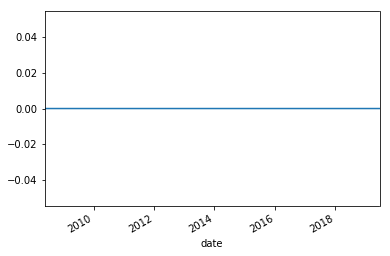

In [91]:
env.envs[0].df_render['Action'].plot()

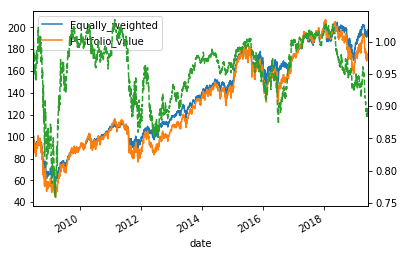

In [92]:
# plt.figure(figsize = (15,10))

# df_to_plot = env.envs[0].render()
df_to_plot = env.envs[0].df_render.iloc[(env.envs[0].lookback_window-2):-2,:][['Portfolio_value', 'Equally_weighted']]   
df_to_plot['diff'] = df_to_plot['Portfolio_value']/df_to_plot['Equally_weighted']

df_to_plot[['Equally_weighted', 'Portfolio_value']].plot()
df_to_plot['diff'].plot(secondary_y = True, style = '--')

In [37]:
env.envs[0].df_render

,Value,Quality,Carry,Profitability,Size,Momentum,Cash,Equally_weighted,Action,Transaction_cost,Portfolio_value
date,,,,,,,,,,,
2008-05-20,108.693363,103.129006,109.590006,105.099638,107.025619,104.491133,100.0,105.432681,0,0.0,100.000000
2008-05-21,107.056119,102.742384,107.522424,104.550592,105.668079,104.696041,100.0,104.605091,0,0.0,100.000000
2008-05-22,107.515881,103.208686,108.071837,104.975683,106.272985,105.033881,100.0,105.011279,0,0.0,100.000000
2008-05-23,105.710759,102.045355,106.805002,103.469999,104.800373,103.039912,100.0,103.695914,0,0.0,100.000000
2008-05-26,105.368570,102.048820,106.595670,103.150634,104.421724,102.775346,100.0,103.480109,0,0.0,100.000000
2008-05-27,105.029890,101.949046,106.074709,102.848768,103.756172,102.344130,100.0,103.143245,0,0.0,100.000000
2008-05-28,106.376420,103.009139,107.019754,104.124042,105.057730,103.305126,100.0,104.127459,0,0.0,100.000000
2008-05-29,106.197429,103.560664,106.777227,104.394555,105.500136,104.028143,100.0,104.351165,0,0.0,100.000000
2008-05-30,106.972473,103.799012,107.249411,104.834958,105.689850,104.232403,100.0,104.682587,0,0.0,100.000000


In [ ]:
last_env = env.envs[0]